# Text to Speech models (neural readers)

* [tacotron(google) group](https://google.github.io/tacotron/)
* [baidu language and speech](http://research.baidu.com/Research_Areas/index-view?id=56)


# Problem statement

- Modern text to speech can be described as a seq2seq model. Given <text,audio> pairs we want to train a model which can predict audio/spectrogram from text.


$$ \huge {(c_1, c_2, c_N ) \mapsto (s_1, s_2, s_T) }$$

- Text can be viewed as a compressed code of a corresponding speech. Imagine word "Hello" pronounced by every person on our planet, it's at least 7.5 billion of different pronunciations all of which correspond to same text code! 

### What makes task of speech synthessis hard?

- Single text code, but multiple pronunciations.
- Variety of emotions and prosody.
- Importance of stress in tonal languages.
- Ambigous text encodings, words can be written in exactly same way but pronounced differently depending on context. Like __read__ _[ˈɹid]_ and __read__ _[ˈɹɛd]_

# Single Speaker Text to Speech. Tacotron

<img src="assets/tacotron.png" alt="tacotron" style="width: 500px;"/>

Image from [Tacotron2](https://arxiv.org/abs/1712.05884)

# Encoder

Encodes individual letters to rich contexctual representation.

1. Embed each letter to high-dim vector.
2. Apply a stack of convolutional layers in order to blend information from neighborning letters.

As a results vectors which correspond to letters can be though of as n-grams, since they now hold usefull information about neinghboring letters, hence necessary pronunciation details for a particular language.


<img src="assets/encoder.jpeg" alt="encoder" style="height: 250px;"/>

# Decoder
- Autoregressive module, predicts next frame $S_t$ of a spectrogram given $ S_{t-1} $  __frame__  and __attention context__
- Converts reach contextual representation into spectrogram.
- Usually has a convolution based architecture.

<img src="assets/decoder.jpeg" alt="decoder" style="height: 300px;"/>

# Attention
- Most fragile component of modern TTS. Serves to connect Encoder with Decoder. Via alignment between letters and spectrogram frames. Tells us duration of each individual letter. Better be monotonic.

- Attention can be represented as a set of correlations between query spectrogram frame and memory bank(encoded letters).
- We want attention to guide a process of speech synthesis.

In [88]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Audio 
%matplotlib inline

It has used other Treasury law enforcement agents on special experiments


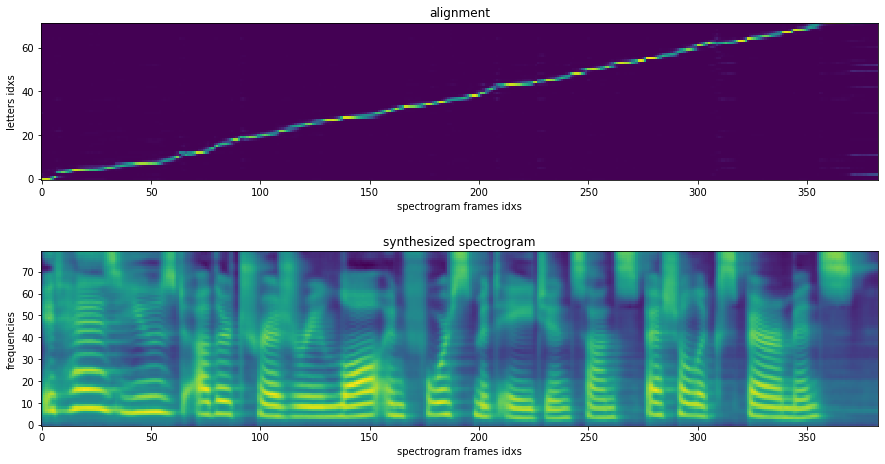

In [89]:
input_text = 'It has used other Treasury law enforcement agents on special experiments'
print(input_text)
alignment_path = pathlib.Path('data/LJ050-0234.alignment.npy')
alignment = np.load(alignment_path)

spectro_path = pathlib.Path('data/LJ050-0234.spectro.npy')
spectro = np.load(spectro_path)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].imshow(alignment, origin='lower')
axes[0].set_title('alignment')
axes[0].set_ylabel('letters idxs')
axes[0].set_xlabel('spectrogram frames idxs')

axes[1].imshow(spectro, origin='lower')
axes[1].set_title('synthesized spectrogram')
axes[1].set_ylabel('frequencies')
axes[1].set_xlabel('spectrogram frames idxs')

plt.show()

wav_path = pathlib.Path('data/LJ050-0234.synth.wav')
Audio(filename=wav_path)

# Monotonic alignment
Q: Why monotonicity of attention is important for text to speech?

A: We want model to read text, sequentually without jumps to random locations.

Changing focus, or jumping across memory cells at different spatial locations is benefitial when we solve other tasks, like image captioning. But when we are concerned with TTS we want attention being monotonic.

<img src="assets/hard-monotonic-alignment.png"/>

Image from [Online and Linear-Time Attention by Enforcing Monotonic Alignments](https://arxiv.org/abs/1704.00784)

# Teacher Forcing
Learning model which reads text is not a straightforward task. Let's consider an autoregressive decoder. Teacher forcing is a technique which uses ground truth spectrogram frame for predicting next frame. Which makes task of decoder much easier and makes training possible. Otherwise if we'd feed in only predicted frames to predict next frames on training then prediction errors will accumulate and training might get stuck.

Though, on inference time there is no ground truth! And the best what we can do is to feed in past predictions for predicting future frames.


- Teacher forcing on __training__ $ S_{t} = Dec(S_{t-1}, C_{t}) $


- Teacher forcing on __inference__ $ S_{t} = Dec(\hat{S}_{t-1}, C_{t}) $

### Quick look at Griffin-Lim, a simplest vocoder based on phase reconstruction.

Griffin Lim reconstructed audio initialized from a random phase.


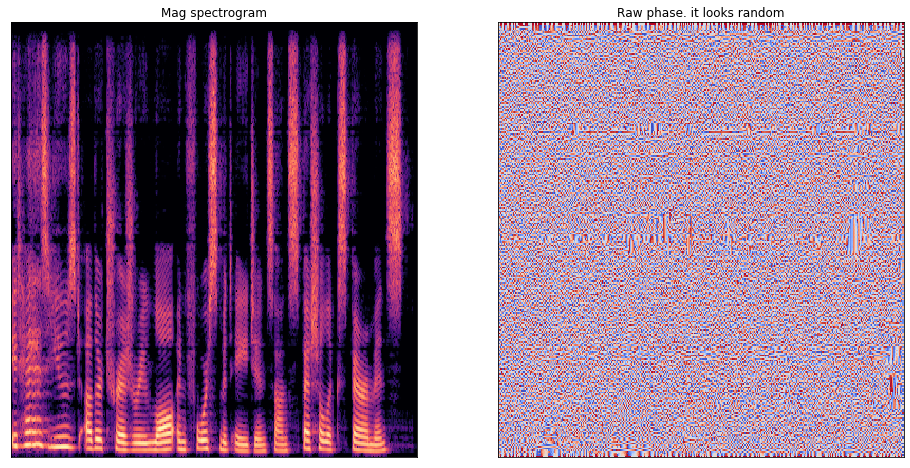

In [90]:
import librosa
import librosa.display
import torch

from stft import STFT

wav, sr = librosa.load(wav_path, sr=None)

stft_layer = STFT(filter_length=512, win_length=512, hop_length=256)
mag, phase = stft_layer.transform(torch.from_numpy(wav).unsqueeze(0))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Mag spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(mag[0], ref=np.max), sr=sr)
plt.subplot(1, 2, 2)
plt.title('Raw phase. it looks random')
librosa.display.specshow(phase.numpy()[0], sr=sr)

griffinlim_wav = librosa.griffinlim(mag.numpy()[0], win_length=512, hop_length=256)
print('Griffin Lim reconstructed audio initialized from a random phase.')
Audio(griffinlim_wav, rate=22050)

# How basic tacotron TTS can be extended?

### 1. Phonemes. IPA. why we might need them?
Phoneme is a unit of speech, it gives much better graphical representation of speech then letters do.

<img src="assets/ipa.png" style="height: 700px;"/>

### Benefits of using phonemes:
- Phonemes are speech units, so they have a direct correspondance to speech we are aiming to synthesise
- Attention in space of letters is ill defined, for word __better [bɛɾɚ]__ double "tt" should be aligned to same speech frames, and it's not clear what durations should be assigned to each individual "t" this doesn't happen in space of phonemes
- International Phones Alphabet (IPA) gives opportunities to train multi-lingual TTS models.

### phonemize
- supports multiple backends: espeak, mbrola, segments
- espeak backend supports multiple languages.

Espeak-NG backend, a next generation of espeak supports 120 languages!

In [13]:
from phonemizer import phonemize
phonemize.phonemize('Phonemes are cool and coordination of model is much better when you use them', language='en-us', backend='espeak')

'foʊniːmz ɑːɹ kuːl ænd koʊɔːɹdᵻneɪʃən ʌv mɑːdəl ɪz mʌtʃ bɛɾɚ wɛn juː juːz ðɛm '

In [14]:
phonemize.phonemize('Фонеми - це елегантний спосіб кодувати текст не залежно від мови!', language='uk', backend='espeak')

'fʌnemi tsɛ iɭiɡɑntnij sposip kʌduvati tekst ne zaɭeʒnʌ vid movi '

In [24]:
import random

languages = list(phonemize.EspeakBackend.supported_languages().values())
print('Some of espeak-ng supported languages:')
print('')
random.shuffle(languages)
for lang in languages[:10]:
    print(lang)


Some of espeak-ng supported languages:

Sinhala
Turkmen
Interlingua
Nepali
Korean
Lojban
English (Scotland)
Hungarian
Chinese (Mandarin)
Tamil


#### Great plan to finally make english spelling easier!

A Plan for the Improvement of Spelling in the English Language

By Mark Twain or maybe not (as sometimes stated) :)

For example, in Year 1 that useless letter “c” would be dropped to be replased either by “k” or “s”, and likewise “x” would no longer be part of the alphabet. The only kase in which “c” would be retained would be the “ch” formation, which will be dealt with later. Year 2 might reform “w” spelling, so that “which” and “one” would take the same konsonant, wile Year 3 might well abolish “y” replasing it with “i” and iear 4 might fiks the “g/j” anomali wonse and for all.

Generally, then, the improvement would kontinue iear bai iear with iear 5 doing awai with useless double konsonants, and iears 6-12 or so modifaiing vowlz and the rimeiniing voist and unvoist konsonants. Bai iear 15 or sou, it wud fainali bi posibl tu meik ius ov thi ridandant letez “c”, “y” and “x”—bai now jast a memori in the maindz ov ould doderez —tu riplais “ch”, “sh”, and “th” rispektivili.

Fainali, xen, aafte sam 20 iers ov orxogrefkl riform, wi wud hev a lojikl, kohirnt speling in ius xrewawt xe Ingliy-spiking werld.

### 2. Multi-Speaker

Building a multi speaker Tacotron will require to specify speaker information as aditional model input.
Speakers can be learned in unsupervised way by updating lernable embeddings with gradients of speaker wrt. loss $ \huge {\frac{\partial L}{\partial s}} $

<img src="assets/enc_with_speaker_emb.png" style="height: 400px"/>

Banchmark multi-speaker dataset [VCTK](https://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html)
contains 109 native speakers of English with various accents.


### 3. Multi-head decoders

It can be benefitial to predict several representations of audio from a single decoder with multiple output heads.
Decoder which predicts Gammatones, Mel-spectrograms, F0 in parallel should learn __more robust features__ which are universaly useful for multiple tasks.

### Perceptual metrics. Mean Opninion Score(MOS)

In order to access naturalness of synthesis, people are asked to judge using  grades in range 1 to 5 on how they like a syhtnesized sample. This metric alos reflects its subjectivness since ground truth only get 4.582 point out of 5.

<img src="assets/mos.png" style="height: 250px">